# Tutoriel Python

* Import des donnees
* Analyse descriptive
* Preparation des donnees
* Creation d’un modele en cross validation
* Calcul des predictions et soumission

# Import des données

Avant de rentrer dans le vif du sujet, importons quelques packages necessaires pour ce tutoriel :

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
train = pd.read_csv('./challenge_miashs_train.csv', encoding='utf-8')
test = pd.read_csv('./challenge_miashs_test.csv', encoding='utf-8')

In [3]:
pd.set_option("display.max_columns", 9999) # permet de voir toutes les colonnes
train.head(3)

libelle  libelle_plaquette  \
0  plaquette(s) thermoformée(s) PVC PVDC aluminiu...                  1   
1  plaquette(s) thermoformée(s) PVC-aluminium de ...                  1   
2  plaquette(s) thermoformée(s) PVC-Aluminium de ...                  1   

   libelle_ampoule  libelle_flacon  libelle_tube  libelle_stylo  \
0                0               0             0              0   
1                0               0             0              0   
2                0               0             0              0   

   libelle_seringue  libelle_pilulier  libelle_sachet  libelle_comprime  \
0                 0                 0               0                 1   
1                 0                 0               0                 0   
2                 0                 0               0                 0   

   libelle_gelule  libelle_film  libelle_poche  libelle_capsule  nb_plaquette  \
0               0             0              0                0             0   
1               1             0              0                0             0   
2               1             0              0                0             0   

   nb_ampoule  nb_flacon  nb_tube  nb_stylo  nb_seringue  nb_pilulier  \
0           0          0        0         0            0            0   
1           0          0        0         0            0            0   
2           0          0        0         0            0            0   

   nb_sachet  nb_comprime  nb_gelule  nb_film  nb_poche  nb_capsule  nb_ml  \
0          0           15          0        0         0           0    0.0   
1          0            0         20        0         0           0    0.0   
2          0            0         16        0         0           0    0.0   

                statut                      etat commerc agrement col  \
0  Présentation active  Déclaration de commercialisation          oui   
1  Présentation active  Déclaration de commercialisation          oui   
2  Présentation active  Déclaration de commercialisation          oui   

  tx rembours        forme pharma voies admin         statut admin  \
0         30%  comprimé pelliculé       orale  Autorisation active   
1         30%              gélule       orale  Autorisation active   
2         65%              gélule       orale  Autorisation active   

   date declar annee  date amm annee                             type proc  \
0               2010            2008  Procédure de reconnaissance mutuelle   
1               1976            1990                   Procédure nationale   
2               1998            1986                   Procédure nationale   

       titulaires                                       substances  prix  
0        BIOGARAN  CHLORHYDRATE DE FEXOFÉNADINE, FEXOFÉNADINE BASE  2.24  
1   JANSSEN CILAG    LOPÉRAMIDE (CHLORHYDRATE DE), LOPÉRAMIDE BASE  2.32  
2        BIOGARAN                                      PARACÉTAMOL  1.08

# Analyse descriptive

### Structure des datasets

Le dataset ```train``` comporte les caracteristiques et prix de ~6000 boites de medicaments. C'est ce dataset que nous allons utiliser pour creer un modele.
Chaque boite de medicament est decrite par une observation de 41 variables. Ces variables sont decrites dans le fichier `Description.pdf` present dans la cle usb.

Le dataset ```test``` comporte les caracteristiques des ~2000 boites de medicaments dont il faut predire le prix. A la difference de ```train```, le prix des boites de medicaments n'est bien sur pas inclus.

### Distribution des donnees

Jetons maintenant un coup d'oeil a la distribution des donnees

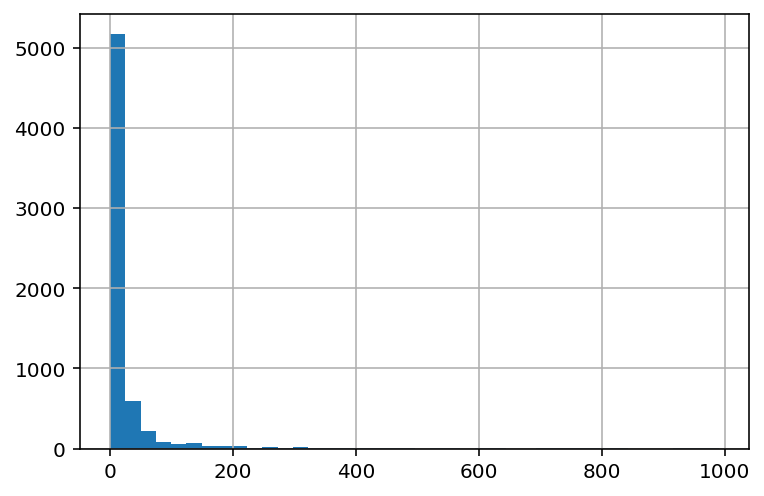

In [4]:
train['prix'].hist(bins=40);
train.prix=np.log(train.prix)

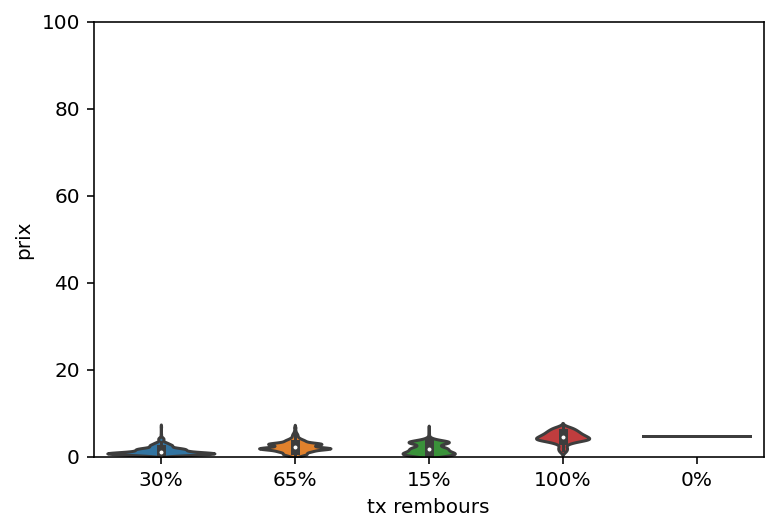

In [5]:
# Influence sur les prix de la feature "tx rembours"
plt.ylim(0, 100)
sns.violinplot(y="prix", x="tx rembours", data=train);

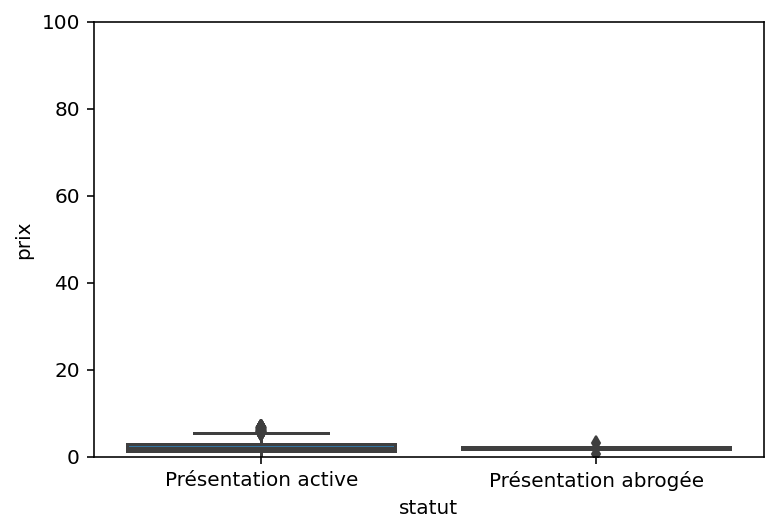

In [6]:
# Influence sur les prix de la feature "statut"
plt.ylim(0, 100)
sns.boxplot(y="prix", x="statut", data=train);

# Preparation des donnees

In [7]:
# On rassemble pour le feature engineering
df = pd.concat([train,test])
train.head(2)

libelle  libelle_plaquette  \
0  plaquette(s) thermoformée(s) PVC PVDC aluminiu...                  1   
1  plaquette(s) thermoformée(s) PVC-aluminium de ...                  1   

   libelle_ampoule  libelle_flacon  libelle_tube  libelle_stylo  \
0                0               0             0              0   
1                0               0             0              0   

   libelle_seringue  libelle_pilulier  libelle_sachet  libelle_comprime  \
0                 0                 0               0                 1   
1                 0                 0               0                 0   

   libelle_gelule  libelle_film  libelle_poche  libelle_capsule  nb_plaquette  \
0               0             0              0                0             0   
1               1             0              0                0             0   

   nb_ampoule  nb_flacon  nb_tube  nb_stylo  nb_seringue  nb_pilulier  \
0           0          0        0         0            0            0   
1           0          0        0         0            0            0   

   nb_sachet  nb_comprime  nb_gelule  nb_film  nb_poche  nb_capsule  nb_ml  \
0          0           15          0        0         0           0    0.0   
1          0            0         20        0         0           0    0.0   

                statut                      etat commerc agrement col  \
0  Présentation active  Déclaration de commercialisation          oui   
1  Présentation active  Déclaration de commercialisation          oui   

  tx rembours        forme pharma voies admin         statut admin  \
0         30%  comprimé pelliculé       orale  Autorisation active   
1         30%              gélule       orale  Autorisation active   

   date declar annee  date amm annee                             type proc  \
0               2010            2008  Procédure de reconnaissance mutuelle   
1               1976            1990                   Procédure nationale   

       titulaires                                       substances      prix  
0        BIOGARAN  CHLORHYDRATE DE FEXOFÉNADINE, FEXOFÉNADINE BASE  0.806476  
1   JANSSEN CILAG    LOPÉRAMIDE (CHLORHYDRATE DE), LOPÉRAMIDE BASE  0.841567

In [8]:
# Pas de valeur NaN a combler
train.isna().sum()

libelle              0
libelle_plaquette    0
libelle_ampoule      0
libelle_flacon       0
libelle_tube         0
libelle_stylo        0
libelle_seringue     0
libelle_pilulier     0
libelle_sachet       0
libelle_comprime     0
libelle_gelule       0
libelle_film         0
libelle_poche        0
libelle_capsule      0
nb_plaquette         0
nb_ampoule           0
nb_flacon            0
nb_tube              0
nb_stylo             0
nb_seringue          0
nb_pilulier          0
nb_sachet            0
nb_comprime          0
nb_gelule            0
nb_film              0
nb_poche             0
nb_capsule           0
nb_ml                0
statut               0
etat commerc         0
agrement col         0
tx rembours          0
forme pharma         0
voies admin          0
statut admin         0
date declar annee    0
date amm annee       0
type proc            0
titulaires           0
substances           0
prix                 0
dtype: int64

In [9]:
# Concentrons nous pour le benchmark sur les variables deja au type numerique
df.dtypes

libelle               object
libelle_plaquette      int64
libelle_ampoule        int64
libelle_flacon         int64
libelle_tube           int64
libelle_stylo          int64
libelle_seringue       int64
libelle_pilulier       int64
libelle_sachet         int64
libelle_comprime       int64
libelle_gelule         int64
libelle_film           int64
libelle_poche          int64
libelle_capsule        int64
nb_plaquette           int64
nb_ampoule             int64
nb_flacon              int64
nb_tube                int64
nb_stylo               int64
nb_seringue            int64
nb_pilulier            int64
nb_sachet              int64
nb_comprime            int64
nb_gelule              int64
nb_film                int64
nb_poche               int64
nb_capsule             int64
nb_ml                float64
statut                object
etat commerc          object
agrement col          object
tx rembours           object
forme pharma          object
voies admin           object
statut admin  

In [10]:
numeric_var_list = df.dtypes[df.dtypes == 'int64'].index
numeric_var_list

Index(['libelle_plaquette', 'libelle_ampoule', 'libelle_flacon',
       'libelle_tube', 'libelle_stylo', 'libelle_seringue', 'libelle_pilulier',
       'libelle_sachet', 'libelle_comprime', 'libelle_gelule', 'libelle_film',
       'libelle_poche', 'libelle_capsule', 'nb_plaquette', 'nb_ampoule',
       'nb_flacon', 'nb_tube', 'nb_stylo', 'nb_seringue', 'nb_pilulier',
       'nb_sachet', 'nb_comprime', 'nb_gelule', 'nb_film', 'nb_poche',
       'nb_capsule', 'date declar annee', 'date amm annee'],
      dtype='object')

# Feature Engineering

In [42]:
df = df.rename(columns={'voies admin':'voies_admin','tx rembours':'tx_rembours','forme pharma':'forme_pharma','date amm annee':'date_amm_annee','type proc':'type_proc'})
df.head()

libelle  libelle_plaquette  \
0  plaquette(s) thermoformée(s) PVC PVDC aluminiu...                  1   
1  plaquette(s) thermoformée(s) PVC-aluminium de ...                  1   
2  plaquette(s) thermoformée(s) PVC-Aluminium de ...                  1   
3                     1 flacon(s) en verre de 10  ml                  0   
4  4 seringue(s) préremplie(s) polypropylène jaun...                  0   

   libelle_ampoule  libelle_flacon  libelle_tube  libelle_stylo  \
0                0               0             0              0   
1                0               0             0              0   
2                0               0             0              0   
3                0               1             0              0   
4                0               0             0              0   

   libelle_seringue  libelle_pilulier  libelle_sachet  libelle_comprime  \
0                 0                 0               0                 1   
1                 0                 0               0                 0   
2                 0                 0               0                 0   
3                 0                 0               0                 0   
4                 1                 0               0                 0   

   libelle_gelule  libelle_film  libelle_poche  libelle_capsule  nb_plaquette  \
0               0             0              0                0             0   
1               1             0              0                0             0   
2               1             0              0                0             0   
3               0             0              0                0             0   
4               0             0              0                0             0   

   nb_ampoule  nb_flacon  nb_tube  nb_stylo  nb_seringue  nb_pilulier  \
0           0          0        0         0            0            0   
1           0          0        0         0            0            0   
2           0          0        0         0            0            0   
3           0          1        0         0            0            0   
4           0          0        0         0            4            0   

   nb_sachet  nb_comprime  nb_gelule  nb_film  nb_poche  nb_capsule  nb_ml  \
0          0           15          0        0         0           0    0.0   
1          0            0         20        0         0           0    0.0   
2          0            0         16        0         0           0    0.0   
3          0            0          0        0         0           0   10.0   
4          0            0          0        0         0           0    1.0   

                statut                      etat commerc agrement col  \
0  Présentation active  Déclaration de commercialisation          oui   
1  Présentation active  Déclaration de commercialisation          oui   
2  Présentation active  Déclaration de commercialisation          oui   
3  Présentation active  Déclaration de commercialisation          oui   
4  Présentation active  Déclaration de commercialisation          oui   

  tx_rembours           forme_pharma     voies_admin         statut admin  \
0         30%     comprimé pelliculé           orale  Autorisation active   
1         30%                 gélule           orale  Autorisation active   
2         65%                 gélule           orale  Autorisation active   
3         65%  suspension injectable    sous-cutanée  Autorisation active   
4         65%               solution  buccogingivale  Autorisation active   

   date declar annee  date_amm_annee                             type_proc  \
0               2010            2008  Procédure de reconnaissance mutuelle   
1               1976            1990                   Procédure nationale   
2               1998            1986                   Procédure nationale   
3               2004            2002                 Procédure centralisée   
4               2012            2011                 

In [43]:
# A vous de jouer
df['nb_chars_substances'] = df.substances.apply(lambda x: len(x))
df['nb_words_substances'] = df.substances.apply(lambda x: len(x.split(' ')))
df['tx_rembours_float'] = df.tx_rembours.apply(lambda x: float(x[:-1])/100)

df_voies_admin = pd.get_dummies(df.voies_admin, prefix='voies_admin')
df = pd.concat([df, df_voies_admin], axis = 1)

df_f_pharma = pd.get_dummies(df.forme_pharma, prefix='forme_pharma')
df = pd.concat([df, df_f_pharma], axis = 1)

df_substances = pd.get_dummies(df.substances, prefix='substances')
df = pd.concat([df, df_substances], axis = 1)

df_type_proc = pd.get_dummies(df.type_proc, prefix='type_proc')
df = pd.concat([df, df_type_proc], axis = 1)

In [44]:
df_drop = df.drop(columns=['voies_admin','tx_rembours','statut admin','type_proc','titulaires','date declar annee','date_amm_annee','etat commerc','agrement col','forme_pharma','substances','statut','libelle'])
df_drop.head()

libelle_plaquette  libelle_ampoule  libelle_flacon  libelle_tube  \
0                  1                0               0             0   
1                  1                0               0             0   
2                  1                0               0             0   
3                  0                0               1             0   
4                  0                0               0             0   

   libelle_stylo  libelle_seringue  libelle_pilulier  libelle_sachet  \
0              0                 0                 0               0   
1              0                 0                 0               0   
2              0                 0                 0               0   
3              0                 0                 0               0   
4              0                 1                 0               0   

   libelle_comprime  libelle_gelule  libelle_film  libelle_poche  \
0                 1               0             0              0   
1                 0               1             0              0   
2                 0               1             0              0   
3                 0               0             0              0   
4                 0               0             0              0   

   libelle_capsule  nb_plaquette  nb_ampoule  nb_flacon  nb_tube  nb_stylo  \
0                0             0           0          0        0         0   
1                0             0           0          0        0         0   
2                0             0           0          0        0         0   
3                0             0           0          1        0         0   
4                0             0           0          0        0         0   

   nb_seringue  nb_pilulier  nb_sachet  nb_comprime  nb_gelule  nb_film  \
0            0            0          0           15          0        0   
1            0            0          0            0         20        0   
2            0            0          0            0         16        0   
3            0            0          0            0          0        0   
4            4            0          0            0          0        0   

   nb_poche  nb_capsule  nb_ml      prix  nb_chars_substances  \
0         0           0    0.0  0.806476                   47   
1         0           0    0.0  0.841567                   45   
2         0           0    0.0  0.076961                   11   
3         0           0   10.0  2.782539                   39   
4         0           0    1.0  4.433551                   36   

   nb_words_substances  tx_rembours_float  voies_admin_auriculaire  \
0                    5               0.30                        0   
1                    5               0.30                        0   
2                    1               0.65                        0   
3                    5               0.65                        0   
4                    4               0.65                        0   

   voies_admin_auriculaire,gingivale,nasale,voie buccale autre  \
0                                                  0             
1                                                  0             
2                                                  0             
3                                                  0             
4                                                  0             

   voies_admin_buccogingivale  voies_admin_cutanée  \
0                           0                    0   
1                           0                    0   
2                           0                    0   
3                           0                    0   
4                           1                    0   

   voies_admin_cutanée,transdermique  voies_admin_dentaire  \
0                                  0                     0   
1                                  0                     0   
2                                  0                     0   
3                               

# On separe a nouveau train et test

In [45]:
df_train = df_drop[:train.shape[0]]
df_test = df_drop[(df.shape[0] - test.shape[0]):]

In [46]:
target_train = df_train.prix
df_train = df_train.drop(columns = ['prix'])
df_test = df_test.drop(columns = ['prix'])

# Creation d'un modele

### Métrique MAPE

La métrique MAPE n'étant pas disponible dans scikit-learn, nous la codons

In [47]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Random Forest

In [48]:
%%time

X_train, X_test, y_train, y_test = train_test_split(df_train, target_train, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf.fit(X_train, y_train)

mape_error(y_test, rf.predict(X_test))

25.775745905420273

In [49]:
from sklearn.model_selection import cross_validate
rf = RandomForestRegressor(n_estimators=100)
cross_validate(rf,df_train,cv=5,n_jobs=-1)

{'fit_time': array([0.36046028, 0.36246562, 0.36296821, 0.36246681, 0.24715734]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([nan, nan, nan, nan, nan])}

Cela veut dire notre modele predit les prix des medicaments avec environ 188% d’erreur en moyenne. Par exemple, si un medicament vaut reellement 100€, notre prediction moyenne est de l'ordre de 288€.

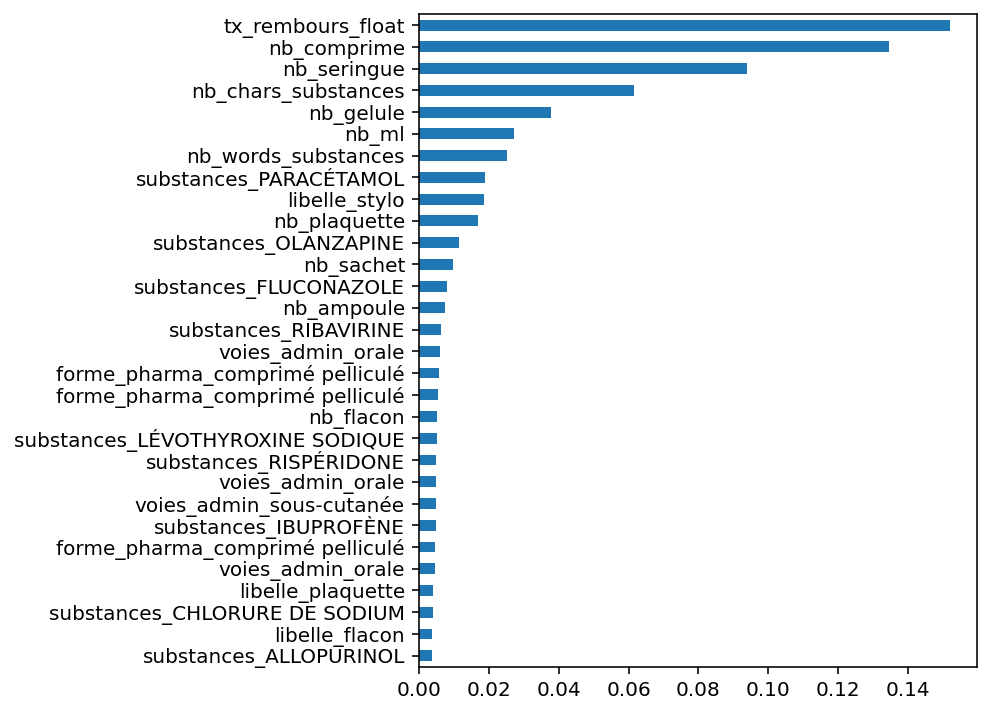

In [31]:
# On visualise les variables importantes selon notre modèle random forest
feat_imp = rf.feature_importances_
df_feat = pd.DataFrame(data=feat_imp, index=X_train.columns)

plt.figure(figsize=(5,6))
feat = df_feat[0].sort_values(ascending=False)
ax = feat.iloc[:30].plot(kind="barh")
ax.invert_yaxis()

# Calcul des predictions et soumission

C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

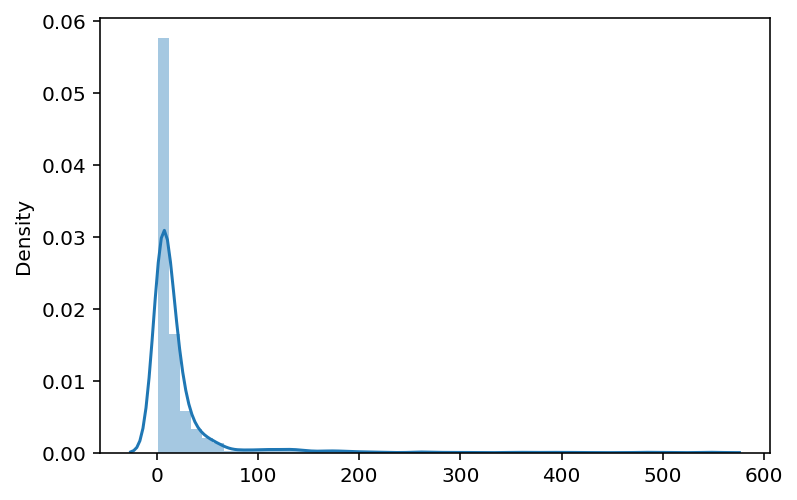

In [32]:
# A vous de jouer
rf.fit(df_train, target_train)
predictions = np.exp(rf.predict(df_test))
sns.distplot(predictions)

In [34]:
assert predictions.shape[0] == 2141
pd.DataFrame(predictions).to_csv('soumission.csv', header=['prix'], index=False)

Faites parvenir votre soumission à Samuel pour qu'il vous donne le score.